Downloading and becoming one with the data

In [13]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-06-25 14:14:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  21.8MB/s    in 7.6s    

2024-06-25 14:14:52 (21.1 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [14]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32


train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical'
                                                          )
print("Testing Images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical'
                                                        )


Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


SETTING UP CALLBACKS
1. Track experiments with the TensorBoard callback
2. Model checkpoint with the ModelCheckpoint callback
3. Stopping a model from training (before it trains too long and overfits) with EarlyStopping callback

In [17]:
# Create TensorBoard callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dirname, experiment_name):
  log_dir = dirname + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log file to: {log_dir}")
  return tensorboard_callback


In [18]:
#Let's compare the following two models
resnet_url = "https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/classification/1"
efficent_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-classification/1"



In [19]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [20]:
# Lets create a create model function to create a model from a URL
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')

  ])
  return model



In [21]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [22]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1001)              25612201  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25622221 (97.74 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 25612201 (97.70 MB)
_________________________________________________________________


In [23]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [32]:
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=30,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data_10_percent,
                 validation_steps=len(test_data_10_percent),
                 callbacks=[create_tensorboard_callback(dirname="tensorflow hub",
                                                        experiment_name="resnet50V2")
                                                        ])

Saving TensorBoard log file to: tensorflow hub/resnet50V2/20240625-152837
Epoch 1/30
24/24 [==============================] - 12s 498ms/step - loss: 2.2188 - accuracy: 0.5947 - val_loss: 2.2079 - val_accuracy: 0.5968
Epoch 2/30
24/24 [==============================] - 12s 494ms/step - loss: 2.2033 - accuracy: 0.6147 - val_loss: 2.1917 - val_accuracy: 0.6100
Epoch 3/30
24/24 [==============================] - 12s 500ms/step - loss: 2.1877 - accuracy: 0.6227 - val_loss: 2.1758 - val_accuracy: 0.6152
Epoch 4/30
24/24 [==============================] - 12s 493ms/step - loss: 2.1722 - accuracy: 0.6253 - val_loss: 2.1600 - val_accuracy: 0.6176
Epoch 5/30
24/24 [==============================] - 11s 469ms/step - loss: 2.1571 - accuracy: 0.6320 - val_loss: 2.1442 - val_accuracy: 0.6260
Epoch 6/30
24/24 [==============================] - 13s 552ms/step - loss: 2.1419 - accuracy: 0.6347 - val_loss: 2.1290 - val_accuracy: 0.6304
Epoch 7/30
24/24 [==============================] - 11s 476ms/step -

In [33]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]
  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="validation loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training accuracy")
  plt.plot(epochs, val_accuracy, label="validation accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


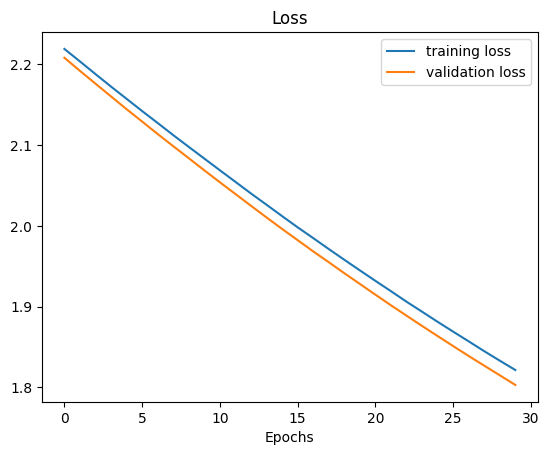

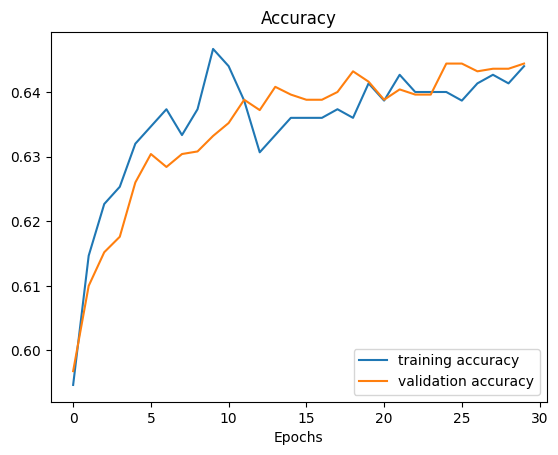

In [34]:
plot_loss_curves(resnet_history)

In [29]:
# Creating EfficentNetB0 tensorflow hub feature extraction model

efficentnet_model = create_model(model_url=efficent_url,
                                 num_classes=train_data_10_percent.num_classes)

efficentnet_model.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

efficentnet_history = efficentnet_model.fit(train_data_10_percent,
                                            epochs=30,
                                            validation_data=test_data_10_percent,
                                            validation_steps=len(test_data_10_percent),
                                            callbacks=[create_tensorboard_callback(dirname="tensorflow_hub",
                                                                                   experiment_name="efficentnetb0")])

Saving TensorBoard log file to: tensorflow_hub/efficentnetb0/20240625-151313
Epoch 1/30
24/24 [==============================] - 20s 496ms/step - loss: 2.3020 - accuracy: 0.0920 - val_loss: 2.2948 - val_accuracy: 0.1248
Epoch 2/30
24/24 [==============================] - 10s 441ms/step - loss: 2.2870 - accuracy: 0.2413 - val_loss: 2.2795 - val_accuracy: 0.3364
Epoch 3/30
24/24 [==============================] - 11s 461ms/step - loss: 2.2721 - accuracy: 0.4440 - val_loss: 2.2643 - val_accuracy: 0.5192
Epoch 4/30
24/24 [==============================] - 10s 431ms/step - loss: 2.2577 - accuracy: 0.5640 - val_loss: 2.2495 - val_accuracy: 0.5836
Epoch 5/30
24/24 [==============================] - 10s 430ms/step - loss: 2.2433 - accuracy: 0.6040 - val_loss: 2.2348 - val_accuracy: 0.6060
Epoch 6/30
24/24 [==============================] - 10s 441ms/step - loss: 2.2291 - accuracy: 0.6160 - val_loss: 2.2204 - val_accuracy: 0.6204
Epoch 7/30
24/24 [==============================] - 10s 440ms/ste

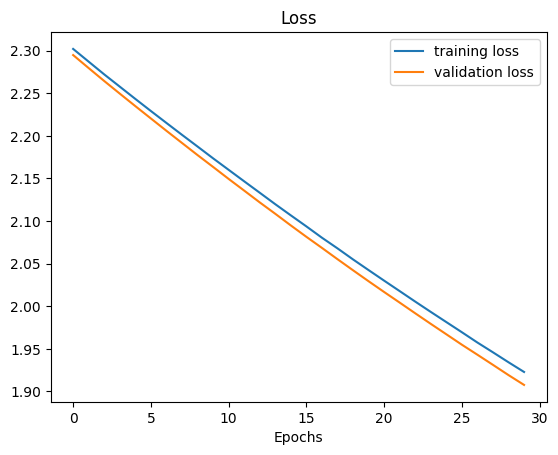

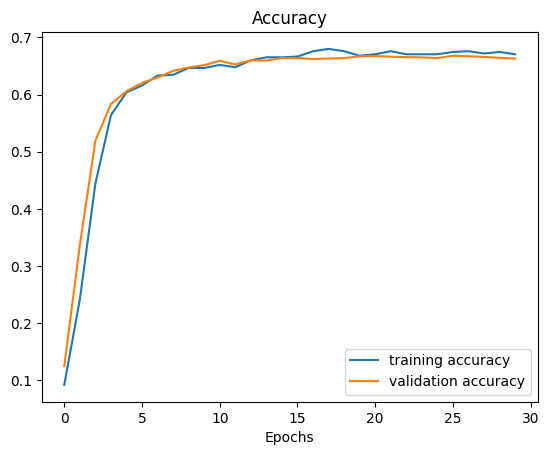

In [30]:
plot_loss_curves(efficentnet_history)

In [31]:
efficentnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1000)              5330564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10010     
                                                                 
Total params: 5340574 (20.37 MB)
Trainable params: 10010 (39.10 KB)
Non-trainable params: 5330564 (20.33 MB)
_________________________________________________________________


In [42]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficentNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models" \
  --one_shot



2024-06-25 15:49:09.868761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 15:49:09.868813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 15:49:09.870089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-25 15:49:10.860151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

In [38]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [41]:
!kill 26679